## Analyzing supplemental payment data in Tenessee
One intent of Medicaid supplemental payments is to reimburse hospitals for the uncompensated care, and also to keep the hospitals that provide critical service to their communities alive. 

Depending on definition, uncompensated care can include Medicaid shortfall, charity care and bad debt, or just Medicaid shortfall and charity care. Other metrics, like Medicaid percentage of adjusted inpatient days, Medicaid percentage of revenue or charges, and number of uninsured patients, can shed light on the burden that hospitals are taking on. 

We take a look at six of TN's safety net hospitals, how they've been doing over time, and how they compare to other hospitals.<br>

TennCare says that the supplemental data is distributed according to 3 year old data. On the other hand, we have some internal document showing that it's two years for three safety net hospitals for money coming from a particular supplemental pool<br>

In [1]:
import pandas as pd
import csv
import re
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import stats
import seaborn as sns
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
os.chdir('Downloads/20210329_LS_TN_medicaid_data')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
def get_yr_rank(data, x, series, year):
    subseries = data[(data.year == year) & (pd.isna(data[series]) == False)][series]
    rank = stats.percentileofscore(subseries, x)
    return(rank)

In [4]:
def get_qt(x):
    if x <= 25:
        return 1
    if (x > 25) & (x <= 50):
        return 2
    if (x > 50) & (x <= 75):
        return 3
    if x > 75:
        return 4
    else:
        return np.nan

In [5]:
def yr_ahead(df,IDcolname,x,varcol,y,yrdiff):
    try:
        newyear = y - yrdiff
        value = df[(df[IDcolname] == x) & (df.year == newyear) ][varcol].iloc[0]
        return value
    except Exception:
        return np.nan

In [6]:
def make_pivot(groupby, col, idx, val):
    df = pd.DataFrame(groupby)
    df = df.reset_index()
    dfpv = df.pivot(columns = col, index = idx, values = val )
    dfpv = dfpv.reset_index()
#     dfpv.columns = [x[1] for x in dfpv.columns]
    return(dfpv)

In [7]:
def add_diff(df, end, start):
    try:
        df['diff'] = df[end]/df[start]-1
    except Exception:
        df.columns = df.columns.to_flat_index()
        df.columns = [x[1] for x in df.columns]
        df['diff'] = df[end]/df[start]-1
    return df

In [8]:
def get_numeric_cols(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    newdf = df.select_dtypes(include=numerics)
    return(list(newdf.columns))

In [9]:
def getfirstnn(a):
    try:
        return(next((item for item in a if item is not None)))
    except Exception:
        return np.nan

In [10]:
nalist = [np.nan, np.inf, -np.inf]

### Importing and prepping data
Data sources
- Joint Annual Report data, 2012-2019<br>
Providers are identified by state ID. NPR and FRONTLINE cleaned up the system names manually to enable system-level analysis
- Medicare Cost report data, all years<br>
Providers are identified by CCN. Each state ID could correspond to one or more CCN (vary by year) and each CCN would correspond to one or several state IDs.<br>
- Supplemenal payments data from TennCare bureau, Tennessee's Mediciad agency, 2015-2019

### JAR data on hospital level and supplemental data from TennCare

In [11]:
data = pd.read_csv('20210430_JAR_TC_data_compile_1.csv')

In [12]:
# labelling the safety net hospitals with information from TennCare bureau.
# 90411 Woodridge Psychiatric Hospital is included in Johnson City but is not included here because it's a psychiatric hospital. Our analyssi focuses on acute care
safetylist = [19244, 79246,33203,33213,33233,19284,47282,90281]
data['type'] = ['safety_net' if y in safetylist else 'non_safety_net' for (x,y) in zip(data.type ,data.state_id)]

In [13]:
# editing some seemingly data entry errors on type after eyeballig
typeidx = data.columns.get_loc('type')
data.iloc[data[(data.state_id == 46201) & (data.year == 2019)].index,typeidx] = 'non_safety_net'
data.iloc[data[(data.state_id == 49206) & (data.year == 2018)].index,typeidx] = 'non_safety_net'
data.iloc[data[(data.state_id == 49206) & (data.year == 2019)].index,typeidx] = 'non_safety_net'

In [14]:
systemraw = pd.read_excel('20210416_data_note_spreadsheets.xlsx','System Names')

In [15]:
systemname = systemraw[['state_id','system_name','year']].copy().drop_duplicates()

In [16]:
# edit the system names of Erlanger Bledsoe and Johnson City since they are safety nets and need to be broken out
sysnameidx = systemname.columns.get_loc('system_name')
systemname.iloc[systemname[systemname.state_id == 90281].index,sysnameidx] = 'Johnson City'
systemname.iloc[systemname[systemname.state_id == 4213].index,sysnameidx] = 'Erlanger Bledsoe'

In [17]:
data1 = pd.merge(data, systemname, on = ['state_id','year'], how  = 'left')

In [18]:
# filling the system name of 2012-2015 with what's in 2015
rawslice = data1[['state_id', 'system_name_y']]
rawsliceagg = rawslice.groupby('state_id').agg(lambda system_name_y: system_name_y.tolist() )
rawsliceagg.columns = ['system_name_list']
rawsliceagg['system_name_fill'] = [getfirstnn(x) for x in rawsliceagg.system_name_list]

In [19]:
data2 = pd.merge(data1, rawsliceagg, on = 'state_id', how = 'left')
data2.system_name_y = [x if pd.isna(x) == False else y for (x,y) in zip (data2.system_name_y, data2.system_name_fill)]

In [20]:
data = data2.drop(['system_name_list','system_name_fill'], axis = 1).copy()

A metric we're using in the analysis is uncompensated care costs.

We’re using JAR report data to calculate uncompensated care costs by calculating the costs of charity care, bad debt and Medicaid shortfall. We then took the uncompensated care costs and compared them with the supplemental payment amounts of the same year. We compared 2015-2019 uncompensated care costs against 2015-2019 supplemental payments.   

Calculation - including bad debt<br>
Cost_charge_ratio = total_expenses/total_charges <br>
medicaid_shortfall = medicaid_charges * cost_charge_ratio - medicaid_revenue; <br>
charity_cost = total_charity_care * cost_charge_ratio<br>
Charity_and_bad_debt_cost = total_charity_and_bad_debt * cost_charge_ratio<br>
Total uncompensated care = Charity_and_bad_debt_cost  + medicaid_shortfall<br>
<br>
Calculation - excluding bad debt<br>
Cost_charge_ratio = total_expenses/total_charges <br>
medicaid_shortfall = medicaid_charges * cost_charge_ratio - medicaid_revenue; <br>
charity_cost = total_charity_care * cost_charge_ratio<br>
Total uncompensated care = Charity_cost  + medicaid_shortfall<br>

There is not one way to calculate uncomenpsated care. Methodology varies over time and in different agencies. For example, TennCare stopped counting bad debt as part of uncompensated care starting 2019, and CMS runs an annual audit on Disproportionate Share Hospital and calculates uncompensated care on their own methodology. Importantly, CMS excludes third party payments, which can sometimes mean a 50% fall in their uncompensated care costs.

In [21]:
# calculating uncompensated care costs.
data['cost_charge_ratio'] = data.total_expenses/data.total_charges
data['shortfall'] = data.medicaid_charges * data.cost_charge_ratio - data.medicaid_revenue
data['cc_bd_cost'] = data.charity_and_bad_debt * data.cost_charge_ratio
data['charity_cost'] = data.charity * data.cost_charge_ratio
data['uc_cc'] = data.shortfall + data.charity_cost
data['uc_cc_bd'] = data.shortfall + data.cc_bd_cost 

# some other variables that should not be calculated after aggregation
data['medicaid_adjusted_inpatient'] = data.medicaid_inpatient*((data.medicaid_inpatient_charge + data.medicaid_outpatient_charge)/data.medicaid_inpatient_charge)
data['total_adjusted_inpatient'] = data.total_inpatient*((data.total_inpatient_charge + data.total_outpatient_charge)/data.total_inpatient_charge)

In [22]:
dataraw = data.copy()

Note on aggregation - we aren't calculating an aggregate cost to charge ratio and therefore UC on a CCN or system level because they contain multiple hospitals, and the larger player under each ID will have larger sway on the cost to charge ratio, therefore distorting the UC amount of its companions.

In [23]:
# aggregatable variables
data['uc_cc_bd_per_bed'] = data.uc_cc_bd/data.beds
data['uc_cc_per_bed'] = data.uc_cc/data.beds
# normalizing supplemental with bed 
data['supplemental_per_bed'] = data.total_supplemental/data.beds
# calculating supplementals as a percentage of UCcosts
data['supp_uc_cc'] = data.total_supplemental/data.uc_cc
data['supp_uc_cc_bd'] = data.total_supplemental/data.uc_cc_bd
# payer mix
data['medicaid_pct_charges'] = data.medicaid_charges/data.total_charges
data['medicaid_pct_revenue'] = data.medicaid_revenue/data.net_patient_revenue
data['medicaid_pct_adjusted_inpatient'] = data.medicaid_adjusted_inpatient/data.total_adjusted_inpatient
#profit
data['gross_profit'] = data.total_revenue - data.total_expenses
data['supp_gross_profit'] = data.total_supplemental/data.gross_profit

In [24]:
# get yearly rank on select variables. The idea is how much supplemental they're getting that year relative to other hospitals....
data['supplemental_per_bed_rank'] = [get_yr_rank(data,x,"supplemental_per_bed", y) for (x,y) in zip(data.supplemental_per_bed,data.year) ]

In [25]:
# TennCare told us that supplemental payments is based on JAR data three years ago, we need to take a look at the lag 
aheadlist = [
             'uc_cc_bd',
             'uc_cc',
                        ]

In [26]:
for col in aheadlist:
    newname = col + '_3'
    series = [yr_ahead(data,'state_id', x, col, y, 3) for (x,y) in zip(data.state_id, data.year)]
    if np.isnan(series).all() == False:
        data[newname] = series
    else:
        continue

In [27]:
for col in ['uc_cc','uc_cc_bd']:
    newname = col + '_2'
    series = [yr_ahead(data,'state_id', x, col, y, 2) for (x,y) in zip(data.state_id, data.year)]
    if np.isnan(series).all() == False:
        data[newname] = series
    else:
        continue

In [28]:
data = data[(data.acute_care == 'yes')].copy().drop_duplicates()

In [29]:
hcalist = [33383, 33393, 58233,11204, 19214, 19324, 19334, 19344, 22204, 75234, 83204, 83254]

In [30]:
hcadf = data[data.state_id.isin(hcalist)]

### dataraw aggregated on a system level
JAR doesn't define a health system means, and there are some inconsistencies in how hospitals report.<br>

According to Agency for Healthcare, Research and Quality, hospital systems are defined as "include at least one hospital and at least one group of physicians providing comprehensive care, and who are connected with each other and with the hospital through common ownership or joint management." See their 2018 compendium page https://www.ahrq.gov/chsp/data-resources/compendium-2018.html

Because hospitals in a system can share resources in a way a standalone hospital cannot, we try to analyze hospitals in systems. System names used here are from DOH and manually cleaned up <br>

In [31]:
dataraw2numcols = get_numeric_cols(dataraw)
dataraw2numcols.append('system_name_y')

In [32]:
dataraw2 = dataraw[dataraw2numcols].copy()
dataraw2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1340 entries, 0 to 1339
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      1340 non-null   int64  
 1   state_id                        1340 non-null   int64  
 2   ccn                             1308 non-null   float64
 3   zipcode                         1337 non-null   float64
 4   part_of_system                  1340 non-null   int64  
 5   total_charges                   1332 non-null   float64
 6   medicaid_inpatient_charge       1310 non-null   float64
 7   medicaid_outpatient_charge      1249 non-null   float64
 8   total_revenue                   1331 non-null   float64
 9   bad_debt                        1332 non-null   float64
 10  net_patient_revenue             1332 non-null   float64
 11  charity                         1332 non-null   float64
 12  charity_and_bad_debt            13

In [33]:
sysdf = dataraw2.pivot_table(index =['system_name_y','year'], aggfunc = 'sum')
sysdf = sysdf.reset_index()
sysdf = sysdf.rename(columns = {'system_name_y':'sysname'})

In [34]:
for col in aheadlist:
    newname = col + '_3'
    series = [yr_ahead(sysdf,'sysname', x, col, y, 3) for (x,y) in zip(sysdf.sysname, sysdf.year)]
    if np.isnan(series).all() == False:
        sysdf[newname] = series
    else:
        continue

In [35]:
for col in ['uc_cc','uc_cc_bd']:
    newname = col + '_2'
    series = [yr_ahead(sysdf,'sysname', x, col, y, 2) for (x,y) in zip(sysdf.sysname, sysdf.year)]
    if np.isnan(series).all() == False:
        sysdf[newname] = series
    else:
        continue

In [36]:
# aggregatable variables
sysdf['uc_cc_bd_per_bed'] = sysdf.uc_cc_bd/sysdf.beds
sysdf['uc_cc_per_bed'] = sysdf.uc_cc_bd/sysdf.beds

#calculating supplementals as a percentage of UCcosts
sysdf['supp_uc_cc'] = sysdf.total_supplemental/sysdf.uc_cc
sysdf['supp_uc_cc_bd'] = sysdf.total_supplemental/sysdf.uc_cc_bd
sysdf['supp_uc_cc_3'] = sysdf.total_supplemental/sysdf.uc_cc_3
sysdf['supp_uc_cc_bd_3'] = sysdf.total_supplemental/sysdf.uc_cc_bd_3
sysdf['supp_uc_cc_2'] = sysdf.total_supplemental/sysdf.uc_cc_2
sysdf['supp_uc_cc_bd_2'] = sysdf.total_supplemental/sysdf.uc_cc_bd_2
# normalizing supplemental per bed 
sysdf['supplemental_per_bed'] = sysdf.total_supplemental/sysdf.beds
# sysdf['supplemental_uninsured'] = sysdf.total_supplemental/sysdf.total_uninsured_cnt

# payer mix
sysdf['medicaid_pct_charges'] = sysdf.medicaid_charges/sysdf.total_charges
sysdf['medicaid_pct_revenue'] = sysdf.medicaid_revenue/sysdf.net_patient_revenue
sysdf['medicaid_pct_adjusted_inpatient'] = sysdf.medicaid_adjusted_inpatient/sysdf.total_adjusted_inpatient
# profit
sysdf['gross_profit'] = sysdf.total_revenue - sysdf.total_expenses
sysdf['supp_gross_profit'] = sysdf.total_supplemental/sysdf.gross_profit

In [37]:
# get yearly rank on select variables.
sysdf['supplemental_per_bed_rank'] = [get_yr_rank(sysdf,x,"supplemental_per_bed", y) for (x,y) in zip(sysdf.supplemental_per_bed,sysdf.year) ]

In [38]:
# break out the state-designated safety-net hospitals and HCA
tgsys = ['HCA'] +  list(data[(data.state_id.isin(safetylist)) & (data.year == 2019)].system_name_y.unique())

## Supplemental payment analysis

### Amount of supplemental payment

In [39]:
print('Supplemental payment, all providers')
data.groupby('year').total_supplemental.sum()

Supplemental payment, all providers


year
2012    0.000000e+00
2013    0.000000e+00
2014    0.000000e+00
2015    7.473273e+08
2016    7.422007e+08
2017    7.452069e+08
2018    7.275430e+08
2019    7.483397e+08
Name: total_supplemental, dtype: float64

In [40]:
print('Total amount of supplemental payment, safety-net vs non-safety_net')
add_diff(make_pivot(data.groupby(['type','year']).total_supplemental.sum(), col = 'year', idx = 'type', val = None),2019,2015)

Total amount of supplemental payment, safety-net vs non-safety_net


,,2012,2013,2014,2015,2016,2017,2018,2019,diff
0,non_safety_net,0.0,0.0,0.0,4.594394e+08,449256950.0,469675825.0,4.239195e+08,4.324743e+08,-0.058691
1,safety_net,0.0,0.0,0.0,2.878879e+08,292943743.0,275531113.0,3.036236e+08,3.158654e+08,0.097182


We can see that the total amounts of supplemental payment has remained stable. There has been some shifts between non-safety-net and safety-net hospitals.

In [41]:
# supplemental payment amount by system
supp_pv = add_diff(sysdf.pivot_table(columns = 'year',index = 'sysname', values = 'total_supplemental'),2019,2015)
supp_pv = supp_pv.reset_index()

In [42]:
print('Ten systems that received the greatest percentage increases in supplemental payment')
supp_pv[~supp_pv['diff'].isin(nalist)].sort_values('diff', ascending = False).head(10)

Ten systems that received the greatest percentage increases in supplemental payment


year,sysname,2012,2013,2014,2015,2016,2017,2018,2019,diff
11,East Tennessee Children's Hospital,0.0,0.0,0.0,8.153627e+06,14706312.0,27947255.0,2.882786e+07,3.268425e+07,3.008554
0,Acadia Healthcare,0.0,0.0,0.0,1.412745e+06,2699533.0,578323.0,4.934721e+06,5.585617e+06,2.953733
35,Sweetwater Hospital Association,0.0,0.0,0.0,6.581170e+05,244452.0,0.0,1.771373e+06,2.264416e+06,2.440751
14,HCA,0.0,0.0,0.0,3.978298e+07,52759689.0,69360484.0,8.823078e+07,8.446916e+07,1.123249
33,Rhea Medical Center,0.0,0.0,0.0,1.919658e+06,1567946.0,1845301.0,1.742659e+06,2.954388e+06,0.539018
19,Johnson City,0.0,0.0,0.0,1.675773e+07,14509034.0,12347215.0,2.396720e+07,2.544515e+07,0.518413
40,West Tennessee Healthcare,0.0,0.0,0.0,5.062351e+06,5346421.0,5617672.0,1.257034e+07,7.510616e+06,0.483622
36,Tenet Healthcare Corporation,0.0,0.0,0.0,1.019375e+07,14166937.0,16518851.0,1.230342e+07,1.208591e+07,0.185620
39,Vanderbilt Health System,0.0,0.0,0.0,1.125982e+08,119665713.0,105277460.0,1.223535e+08,1.333252e+08,0.184080
37,The University of Tennessee Medical Center,0.0,0.0,0.0,1.059611e+07,10528342.0,11002746.0,1.176001e+07,1.187252e+07,0.120460


The shift in amount of supplemental payment shows up on the system level. We noticed that HCA, the largest for-profit hospital chain in the country, ranked high in increase and also has received high amounts of supplemental payment. so we're putting it side by side with the safety-nets for comparison when it comes to other metrics.

In [43]:
supp_pv = add_diff(sysdf.pivot_table(columns = 'year',index = 'sysname', values = 'total_supplemental'),2019,2015)
supp_pv = supp_pv.reset_index()
print ('Supplemental payment, select systems')
supp_pv[supp_pv.sysname.isin(tgsys)]

Supplemental payment, select systems


year,sysname,2012,2013,2014,2015,2016,2017,2018,2019,diff
13,Erlanger Health System,0.0,0.0,0.0,4.843373e+07,4.708975e+07,50647657.0,5.415002e+07,5.401647e+07,0.115265
14,HCA,0.0,0.0,0.0,3.978298e+07,5.275969e+07,69360484.0,8.823078e+07,8.446916e+07,1.123249
19,Johnson City,0.0,0.0,0.0,1.675773e+07,1.450903e+07,12347215.0,2.396720e+07,2.544515e+07,0.518413
26,Metropolitan Nashville General Hospital,0.0,0.0,0.0,2.116205e+07,2.045954e+07,20850403.0,2.135075e+07,1.815891e+07,-0.141912
31,Regional One Health,0.0,0.0,0.0,7.834011e+07,8.069136e+07,75405632.0,7.004214e+07,7.304712e+07,-0.067564
37,The University of Tennessee Medical Center,0.0,0.0,0.0,1.059611e+07,1.052834e+07,11002746.0,1.176001e+07,1.187252e+07,0.120460
39,Vanderbilt Health System,0.0,0.0,0.0,1.125982e+08,1.196657e+08,105277460.0,1.223535e+08,1.333252e+08,0.184080


### Supplemental payment per bed
The per bed measures adjusts for size of the hospital systems

In [44]:
print('Supplemental payment per bed, all providers')
data.groupby('year').total_supplemental.sum()/data.groupby('year').beds.sum()

Supplemental payment per bed, all providers


year
2012        0.000000
2013        0.000000
2014        0.000000
2015    34011.162352
2016    34204.373151
2017    34138.391039
2018    33414.919641
2019    34267.776214
dtype: float64

In [45]:
print('Supplemental payment per bed, safety-net vs. non-safety-net')
gb = data.groupby(['type','year']).total_supplemental.sum()/data.groupby(['type','year']).beds.sum()
add_diff(make_pivot(gb, col = 'year', idx = 'type', val = None),2019,2015)

Supplemental payment per bed, safety-net vs. non-safety-net


,,2012,2013,2014,2015,2016,2017,2018,2019,diff
0,non_safety_net,0.0,0.0,0.0,25148.577711,24965.654348,25913.148966,23494.954836,24091.935340,-0.042016
1,safety_net,0.0,0.0,0.0,77723.516239,79088.483531,74387.449514,81400.422316,81261.992716,0.045526


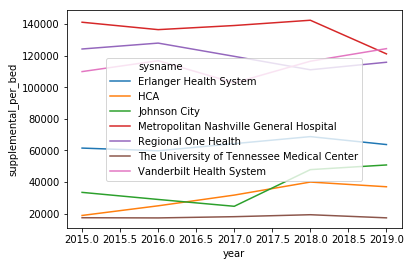

In [46]:
# looking at trendlines by select system
sns.lineplot(data = sysdf[(sysdf.sysname.isin(tgsys)) & (sysdf.year > 2014)], x = 'year', y = 'supplemental_per_bed', hue = 'sysname');

In [47]:
supp_per_bed_pv = add_diff(sysdf.pivot_table(columns = 'year',index = 'sysname', values = 'supplemental_per_bed'),2019,2015)
supp_per_bed_pv = supp_per_bed_pv.reset_index()
print('Ten systems that received the largest percentage increases in supplemental payment per bed between 2015 and 2019')
supp_per_bed_pv[~supp_per_bed_pv['diff'].isin(nalist)].sort_values('diff', ascending = False).head(10)

Ten systems that received the largest percentage increases in supplemental payment per bed between 2015 and 2019


year,sysname,2012,2013,2014,2015,2016,2017,2018,2019,diff
11,East Tennessee Children's Hospital,0.0,0.0,0.0,53642.282895,96752.052632,183863.519737,189656.984316,215027.986532,3.008554
35,Sweetwater Hospital Association,0.0,0.0,0.0,11154.525424,4143.254237,0.000000,30023.268082,38379.939525,2.440751
0,Acadia Healthcare,0.0,0.0,0.0,4106.816860,8331.891975,1784.947531,15230.620313,12694.584269,2.091101
14,HCA,0.0,0.0,0.0,18845.560910,24945.479433,31729.407136,39977.700416,36999.195812,0.963284
33,Rhea Medical Center,0.0,0.0,0.0,76786.320000,62717.840000,73812.040000,69706.360000,118175.520000,0.539018
19,Johnson City,0.0,0.0,0.0,33448.570060,28960.147705,24645.139721,47838.724761,50788.728613,0.518413
36,Tenet Healthcare Corporation,0.0,0.0,0.0,14256.998601,20988.054815,24472.371852,18227.292208,17905.057910,0.255878
39,Vanderbilt Health System,0.0,0.0,0.0,109851.864390,116747.037073,102709.717073,116416.236093,124370.523931,0.132166
16,Hardin Medical Center,0.0,0.0,0.0,7691.224138,7563.775862,6485.517241,5434.034483,8536.396552,0.109888
9,Covenant Health System,0.0,0.0,0.0,21863.672384,22152.042931,21664.170578,22832.657016,23956.065985,0.095702


In [48]:
print ('Supplemental payment per bed, select systems')
supp_per_bed_pv[supp_per_bed_pv.sysname.isin(tgsys)]

Supplemental payment per bed, select systems


year,sysname,2012,2013,2014,2015,2016,2017,2018,2019,diff
13,Erlanger Health System,0.0,0.0,0.0,61464.127602,59758.565330,64273.676396,68718.302030,63698.661657,0.036355
14,HCA,0.0,0.0,0.0,18845.560910,24945.479433,31729.407136,39977.700416,36999.195812,0.963284
19,Johnson City,0.0,0.0,0.0,33448.570060,28960.147705,24645.139721,47838.724761,50788.728613,0.518413
26,Metropolitan Nashville General Hospital,0.0,0.0,0.0,141080.360000,136396.949600,139002.686667,142338.306667,121059.372857,-0.141912
31,Regional One Health,0.0,0.0,0.0,124152.318542,127878.545293,119501.793978,111001.800317,115764.061785,-0.067564
37,The University of Tennessee Medical Center,0.0,0.0,0.0,17399.195402,17287.917898,18066.906404,19310.354680,17332.141606,-0.003854
39,Vanderbilt Health System,0.0,0.0,0.0,109851.864390,116747.037073,102709.717073,116416.236093,124370.523931,0.132166


##### rank of supplemental per bed

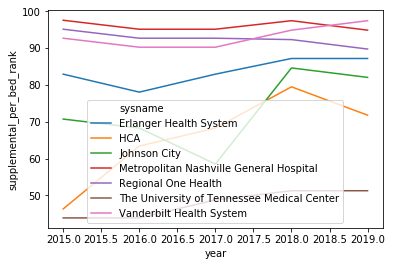

In [49]:
# looking at trendlines by select system
sns.lineplot(data = sysdf[(sysdf.sysname.isin(tgsys)) & (sysdf.year > 2014)], x = 'year', y = 'supplemental_per_bed_rank', hue = 'sysname');

In [50]:
supp_per_bed_rank_pv = add_diff(sysdf.pivot_table(columns = 'year',index = 'sysname', values = 'supplemental_per_bed_rank'),2019,2015)
supp_per_bed_rank_pv = supp_per_bed_rank_pv.reset_index()

In [51]:
print('Percentile of supplemental per bed , select systems')
supp_per_bed_rank_pv[supp_per_bed_rank_pv.sysname.isin(tgsys)]
# it's 51.219512 for everyone before 2015 because we don't have data then.

Percentile of supplemental per bed , select systems


year,sysname,2012,2013,2014,2015,2016,2017,2018,2019,diff
13,Erlanger Health System,51.219512,51.219512,51.219512,82.926829,78.048780,82.926829,87.179487,87.179487,0.051282
14,HCA,51.219512,51.219512,51.219512,46.341463,63.414634,68.292683,79.487179,71.794872,0.549258
19,Johnson City,51.219512,51.219512,51.219512,70.731707,68.292683,58.536585,84.615385,82.051282,0.160035
26,Metropolitan Nashville General Hospital,51.219512,51.219512,51.219512,97.560976,95.121951,95.121951,97.435897,94.871795,-0.027564
31,Regional One Health,51.219512,51.219512,51.219512,95.121951,92.682927,92.682927,92.307692,89.743590,-0.056542
37,The University of Tennessee Medical Center,51.219512,51.219512,51.219512,43.902439,43.902439,48.780488,51.282051,51.282051,0.168091
39,Vanderbilt Health System,51.219512,51.219512,51.219512,92.682927,90.243902,90.243902,94.871795,97.435897,0.051282


## Uncompensated care costs excluding bad debt
In 2019, Tennesse stopped including bad debt in its uncompensated care calculation

In [52]:
print('UC excluding bad debt, all providers')
gb = data.groupby(['year']).uc_cc.sum()
gb

UC excluding bad debt, all providers


year
2012    1.509120e+09
2013    1.538711e+09
2014    1.652661e+09
2015    1.727151e+09
2016    1.897062e+09
2017    2.108721e+09
2018    2.260533e+09
2019    2.446689e+09
Name: uc_cc, dtype: float64

In [53]:
print('UC excluding bad debt, safety-net vs. non-safety net')
gb = data.groupby(['type','year']).uc_cc.sum()
add_diff(make_pivot(gb, col = 'year', idx = 'type', val = None),2019,2015)

UC excluding bad debt, safety-net vs. non-safety net


,,2012,2013,2014,2015,2016,2017,2018,2019,diff
0,non_safety_net,1.080661e+09,1.054952e+09,1.136724e+09,1.267638e+09,1.386114e+09,1.572981e+09,1.721776e+09,1.817004e+09,0.433377
1,safety_net,4.284587e+08,4.837593e+08,5.159370e+08,4.595127e+08,5.109480e+08,5.357394e+08,5.387573e+08,6.296848e+08,0.370332


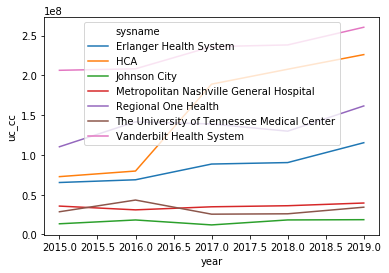

In [54]:
# looking at trendlines by select system
sns.lineplot(data = sysdf[(sysdf.sysname.isin(tgsys)) & (sysdf.year > 2014)], x = 'year', y = 'uc_cc', hue = 'sysname');

In [55]:
uc_cc_pv = add_diff(sysdf.pivot_table(columns = 'year',index = 'sysname', values = 'uc_cc'),2019,2015)
uc_cc_pv = uc_cc_pv.reset_index()
print('Uncompensated care (excluding bad debt), select systems')
uc_cc_pv[uc_cc_pv.sysname.isin(tgsys)]

Uncompensated care (excluding bad debt), select systems


year,sysname,2012,2013,2014,2015,2016,2017,2018,2019,diff
13,Erlanger Health System,5.381773e+07,6.205637e+07,6.181748e+07,6.531212e+07,6.873436e+07,8.851091e+07,9.036160e+07,1.153195e+08,0.765667
14,HCA,5.268463e+07,5.255176e+07,6.465979e+07,7.268052e+07,7.972035e+07,1.889474e+08,2.076831e+08,2.260639e+08,2.110379
19,Johnson City,1.790551e+07,1.842835e+07,1.413221e+07,1.342121e+07,1.822009e+07,1.199974e+07,1.825249e+07,1.858340e+07,0.384629
26,Metropolitan Nashville General Hospital,3.838312e+07,3.837559e+07,3.893084e+07,3.566835e+07,3.092279e+07,3.478486e+07,3.612194e+07,3.951695e+07,0.107900
31,Regional One Health,1.198534e+08,1.449843e+08,1.503249e+08,1.102337e+08,1.415881e+08,1.388653e+08,1.298307e+08,1.615360e+08,0.465396
37,The University of Tennessee Medical Center,3.203961e+07,3.307103e+07,2.769120e+07,2.853730e+07,4.325911e+07,2.549939e+07,2.597448e+07,3.426926e+07,0.200859
39,Vanderbilt Health System,1.664594e+08,1.868436e+08,2.230403e+08,2.063400e+08,2.082235e+08,2.360792e+08,2.382161e+08,2.604598e+08,0.262284


# UC excluding bad debt per bed

In [56]:
print('UC excluding bad debt per bed, all providers')
gb = data[data.type != 'safety_net'].groupby(['year']).uc_cc.sum()/data[data.type != 'safety_net'].groupby(['year']).beds.sum()
gb

UC excluding bad debt per bed, all providers


year
2012     59272.761124
2013     57104.664383
2014     61278.916772
2015     69387.395875
2016     77027.716050
2017     86785.171703
2018     95426.265953
2019    101220.207267
dtype: float64

In [57]:
print('UC excluding bad debt, safety-net vs. non-safety net')
gb = data.groupby(['type','year']).uc_cc.sum()/data.groupby(['type','year']).beds.sum()
add_diff(make_pivot(gb, col = 'year', idx = 'type', val = None),2019,2015)

UC excluding bad debt, safety-net vs. non-safety net


,,2012,2013,2014,2015,2016,2017,2018,2019,diff
0,non_safety_net,59272.761124,57104.664383,61278.916772,69387.395875,77027.71605,86785.171703,95426.265953,101220.207267,0.458769
1,safety_net,119314.596777,133450.833609,140352.823599,124058.496683,137944.92680,144638.063445,144438.961663,161997.631774,0.305816


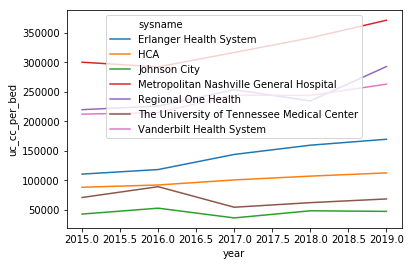

In [58]:
# looking at trendlines by select system
sns.lineplot(data = sysdf[(sysdf.sysname.isin(tgsys)) & (sysdf.year > 2014)], x = 'year', y = 'uc_cc_per_bed', hue = 'sysname');

In [59]:
uc_cc_per_bed_pv = add_diff(sysdf.pivot_table(columns = 'year',index = 'sysname', values = 'uc_cc_per_bed'),2019,2015)
uc_cc_per_bed_pv = uc_cc_per_bed_pv.reset_index()
print('Uncompensated care (not counting bad debt) per bed, select systems')
uc_cc_per_bed_pv[uc_cc_per_bed_pv.sysname.isin(tgsys)]

Uncompensated care (not counting bad debt) per bed, select systems


year,sysname,2012,2013,2014,2015,2016,2017,2018,2019,diff
13,Erlanger Health System,115429.748973,115015.372923,110342.137456,110391.134405,118116.442331,143722.770606,159394.167344,169452.087753,0.535015
14,HCA,69974.889116,71319.882552,82591.309951,88099.704782,91951.102041,100527.538614,106985.426389,112442.465842,0.276309
19,Johnson City,54896.099134,52253.933701,45365.308538,42666.675584,52636.789148,36139.469168,48231.858098,47207.422255,0.106424
26,Metropolitan Nashville General Hospital,339851.124693,321963.454490,334637.828542,300044.607273,292140.617166,316554.194994,341251.318097,371164.530225,0.237031
31,Regional One Health,221994.931109,255193.945556,271755.039959,219580.405292,225672.883027,253549.845731,234424.516509,292657.180259,0.332802
37,The University of Tennessee Medical Center,86800.795359,88038.010220,80771.026231,70757.748712,89057.238978,54244.011856,62023.324357,68284.097946,-0.034959
39,Vanderbilt Health System,187249.593865,202004.627848,237884.781836,211962.727613,214813.506492,244206.384496,243833.302120,262791.280587,0.239799


### Uncompensated care, including bad debt

In [60]:
print('UC including bad debt, all providers')
gb = data[data.type != 'safety_net'].groupby(['year']).uc_cc_bd.sum()
gb

UC including bad debt, all providers


year
2012    1.457975e+09
2013    1.429417e+09
2014    1.515253e+09
2015    1.630297e+09
2016    1.719809e+09
2017    1.826058e+09
2018    1.967160e+09
2019    2.064527e+09
Name: uc_cc_bd, dtype: float64

In [61]:
print('UC inluding bad debt, safety-net vs. non-safety net')
gb = data.groupby(['type','year']).uc_cc_bd.sum()
add_diff(make_pivot(gb, col = 'year', idx = 'type', val = None),2019,2015)

UC inluding bad debt, safety-net vs. non-safety net


,,2012,2013,2014,2015,2016,2017,2018,2019,diff
0,non_safety_net,1.457975e+09,1.429417e+09,1.515253e+09,1.630297e+09,1.719809e+09,1.826058e+09,1.967160e+09,2.064527e+09,0.266350
1,safety_net,5.391958e+08,5.779503e+08,6.221106e+08,5.522794e+08,5.800872e+08,6.221786e+08,6.429173e+08,7.361745e+08,0.332975


In [62]:
print('UC excluding bad debt per bed, all providers')
gb = data[data.type != 'safety_net'].groupby(['year']).uc_cc.sum()/data[data.type != 'safety_net'].groupby(['year']).beds.sum()
gb

UC excluding bad debt per bed, all providers


year
2012     59272.761124
2013     57104.664383
2014     61278.916772
2015     69387.395875
2016     77027.716050
2017     86785.171703
2018     95426.265953
2019    101220.207267
dtype: float64

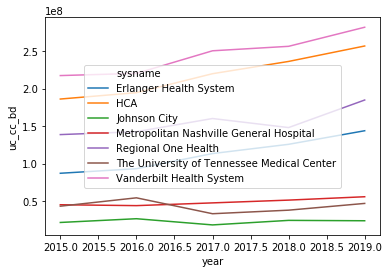

In [63]:
# looking at trendlines by select system
sns.lineplot(data = sysdf[(sysdf.sysname.isin(tgsys)) & (sysdf.year > 2014)], x = 'year', y = 'uc_cc_bd', hue = 'sysname');

In [64]:
uc_cc_bd_pv = add_diff(sysdf.pivot_table(columns = 'year',index = 'sysname', values = 'uc_cc_bd'),2019,2015)
uc_cc_bd_pv = uc_cc_bd_pv.reset_index()
print('Uncompensated care (including bad debt), select systems')
uc_cc_bd_pv[uc_cc_bd_pv.sysname.isin(tgsys)]

Uncompensated care (including bad debt), select systems


year,sysname,2012,2013,2014,2015,2016,2017,2018,2019,diff
13,Erlanger Health System,8.576430e+07,8.545642e+07,8.694960e+07,8.698821e+07,9.307576e+07,1.132535e+08,1.256026e+08,1.436954e+08,0.651895
14,HCA,1.456177e+08,1.485593e+08,1.735243e+08,1.859785e+08,1.944766e+08,2.197532e+08,2.361168e+08,2.567061e+08,0.380300
19,Johnson City,2.750295e+07,2.617922e+07,2.272802e+07,2.137600e+07,2.637103e+07,1.810587e+07,2.416416e+07,2.365092e+07,0.106424
26,Metropolitan Nashville General Hospital,5.097767e+07,4.829452e+07,5.019567e+07,4.500669e+07,4.382109e+07,4.748313e+07,5.118770e+07,5.567468e+07,0.237031
31,Regional One Health,1.400788e+08,1.610274e+08,1.714774e+08,1.385552e+08,1.423996e+08,1.599900e+08,1.479219e+08,1.846667e+08,0.332802
37,The University of Tennessee Medical Center,5.043126e+07,5.115008e+07,4.692797e+07,4.309147e+07,5.423586e+07,3.303460e+07,3.777220e+07,4.677461e+07,0.085473
39,Vanderbilt Health System,1.844408e+08,2.058427e+08,2.438319e+08,2.172618e+08,2.201838e+08,2.503115e+08,2.562688e+08,2.817123e+08,0.296649


# UC including bad debt per bed

In [65]:
print('UC including bad debt per bed, all providers')
gb = data[data.type != 'safety_net'].groupby(['year']).uc_cc_bd.sum()/data[data.type != 'safety_net'].groupby(['year']).beds.sum()
gb

UC including bad debt per bed, all providers


year
2012     79967.888431
2013     77374.532514
2014     81684.803015
2015     89238.457003
2016     95571.465625
2017    100748.047138
2018    109026.207640
2019    115009.027061
dtype: float64

In [66]:
print('UC including bad debt, safety-net vs. non-safety net')
gb = data.groupby(['type','year']).uc_cc_bd.sum()/data.groupby(['type','year']).beds.sum()
add_diff(make_pivot(gb, col = 'year', idx = 'type', val = None),2019,2015)

UC including bad debt, safety-net vs. non-safety net


,,2012,2013,2014,2015,2016,2017,2018,2019,diff
0,non_safety_net,79967.888431,77374.532514,81684.803015,89238.457003,95571.465625,100748.047138,109026.207640,115009.027061,0.288783
1,safety_net,150151.999846,159434.576662,169235.744290,149103.512413,156611.007661,167974.796578,172363.897444,189394.008007,0.270218


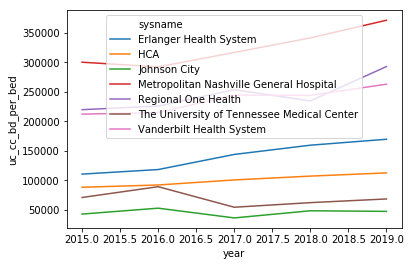

In [67]:
# looking at trendlines by select system
sns.lineplot(data = sysdf[(sysdf.sysname.isin(tgsys)) & (sysdf.year > 2014)], x = 'year', y = 'uc_cc_bd_per_bed', hue = 'sysname');

In [68]:
uc_cc_bd_per_bed_pv = add_diff(sysdf.pivot_table(columns = 'year',index = 'sysname', values = 'uc_cc_bd_per_bed'),2019,2015)
uc_cc_bd_per_bed_pv = uc_cc_bd_per_bed_pv.reset_index()
print('Uncompensated care (not counting bad debt) per bed, select systems')
uc_cc_bd_per_bed_pv[uc_cc_bd_per_bed_pv.sysname.isin(tgsys)]

Uncompensated care (not counting bad debt) per bed, select systems


year,sysname,2012,2013,2014,2015,2016,2017,2018,2019,diff
13,Erlanger Health System,115429.748973,115015.372923,110342.137456,110391.134405,118116.442331,143722.770606,159394.167344,169452.087753,0.535015
14,HCA,69974.889116,71319.882552,82591.309951,88099.704782,91951.102041,100527.538614,106985.426389,112442.465842,0.276309
19,Johnson City,54896.099134,52253.933701,45365.308538,42666.675584,52636.789148,36139.469168,48231.858098,47207.422255,0.106424
26,Metropolitan Nashville General Hospital,339851.124693,321963.454490,334637.828542,300044.607273,292140.617166,316554.194994,341251.318097,371164.530225,0.237031
31,Regional One Health,221994.931109,255193.945556,271755.039959,219580.405292,225672.883027,253549.845731,234424.516509,292657.180259,0.332802
37,The University of Tennessee Medical Center,86800.795359,88038.010220,80771.026231,70757.748712,89057.238978,54244.011856,62023.324357,68284.097946,-0.034959
39,Vanderbilt Health System,187249.593865,202004.627848,237884.781836,211962.727613,214813.506492,244206.384496,243833.302120,262791.280587,0.239799


## Supplemental as a share of uncompensated care

In [69]:
print('Supplemental payment as percentage of UC excluding bad debt, all providers')
gb = data[data.type != 'safety_net'].groupby(['year']).total_supplemental.sum()/data[data.type != 'safety_net'].groupby(['year']).uc_cc.sum()
gb

Supplemental payment as percentage of UC excluding bad debt, all providers


year
2012    0.000000
2013    0.000000
2014    0.000000
2015    0.362437
2016    0.324113
2017    0.298590
2018    0.246211
2019    0.238015
dtype: float64

In [70]:
print('Supplemental payment as percentage of UC excluding bad debt, safety-net vs. non-safety net')
gb = data.groupby(['type','year']).total_supplemental.sum()/data.groupby(['type','year']).uc_cc.sum()
add_diff(make_pivot(gb, col = 'year', idx = 'type', val = None),2019,2015)

Supplemental payment as percentage of UC excluding bad debt, safety-net vs. non-safety net


,,2012,2013,2014,2015,2016,2017,2018,2019,diff
0,non_safety_net,0.0,0.0,0.0,0.362437,0.324113,0.298590,0.246211,0.238015,-0.343293
1,safety_net,0.0,0.0,0.0,0.626507,0.573334,0.514301,0.563563,0.501625,-0.199331


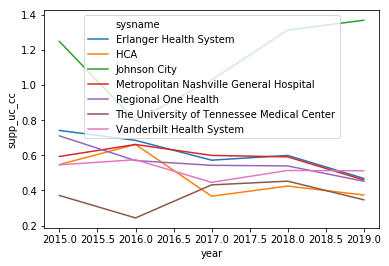

In [71]:
# looking at trendlines by select system
sns.lineplot(data = sysdf[(sysdf.sysname.isin(tgsys)) & (sysdf.year > 2014)], x = 'year', y = 'supp_uc_cc', hue = 'sysname');

In [72]:
# how much of their UC was covered in the same year? 
supp_uc_cc_pv = add_diff(sysdf.pivot_table(columns = 'year',index = 'sysname', values = 'supp_uc_cc'),2019,2015)
supp_uc_cc_pv = supp_uc_cc_pv.reset_index()
print('Supplemental as percentage of uncompensated care (excluding bad debt), select systems')
supp_uc_cc_pv[supp_uc_cc_pv.sysname.isin(tgsys)]

Supplemental as percentage of uncompensated care (excluding bad debt), select systems


year,sysname,2012,2013,2014,2015,2016,2017,2018,2019,diff
13,Erlanger Health System,0.0,0.0,0.0,0.741573,0.685098,0.572219,0.599259,0.468407,-0.368360
14,HCA,0.0,0.0,0.0,0.547368,0.661810,0.367089,0.424834,0.373652,-0.317366
19,Johnson City,0.0,0.0,0.0,1.248601,0.796321,1.028957,1.313092,1.369241,0.096620
26,Metropolitan Nashville General Hospital,0.0,0.0,0.0,0.593301,0.661633,0.599410,0.591074,0.459522,-0.225482
31,Regional One Health,0.0,0.0,0.0,0.710673,0.569902,0.543013,0.539488,0.452203,-0.363697
37,The University of Tennessee Medical Center,0.0,0.0,0.0,0.371307,0.243379,0.431491,0.452752,0.346448,-0.066951
39,Vanderbilt Health System,0.0,0.0,0.0,0.545692,0.574698,0.445941,0.513624,0.511884,-0.061955


#### Uncompensated care costs, two years prior to the supplemental payment
Internal documents we were able to review showed that for some of the safety-net hospitals, a part of the supplemental payment was calculated based on uncompensated care costs two years before, so we took a look at how that affects the trendline

In [73]:
print('Supplemental payment as percentage of UC excluding bad debt, two years ago,all providers')
gb = data.groupby(['year']).total_supplemental.sum()/data.groupby(['year']).uc_cc_2.sum()
gb

Supplemental payment as percentage of UC excluding bad debt, two years ago,all providers


year
2012         NaN
2013         NaN
2014    0.000000
2015    0.486667
2016    0.452648
2017    0.433860
2018    0.383487
2019    0.355925
dtype: float64

In [74]:
print('Supplemental payment as percentage of UC excluding bad debt, two years ago safety-net vs. non-safety net')
gb = data.groupby(['type','year']).total_supplemental.sum()/data.groupby(['type','year']).uc_cc_2.sum()
add_diff(make_pivot(gb, col = 'year', idx = 'type', val = None),2019,2015)

Supplemental payment as percentage of UC excluding bad debt, two years ago safety-net vs. non-safety net


,,2012,2013,2014,2015,2016,2017,2018,2019,diff
0,non_safety_net,NaN,NaN,0.0,0.436794,0.399784,0.373319,0.305807,0.276028,-0.368061
1,safety_net,NaN,NaN,0.0,0.595106,0.567790,0.599616,0.594236,0.589588,-0.009272


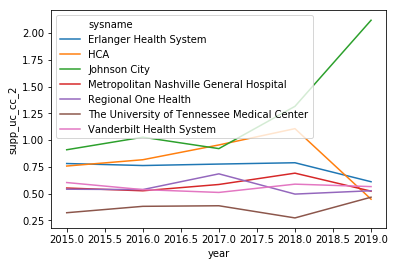

In [75]:
# looking at trendlines by select system
sns.lineplot(data = sysdf[(sysdf.sysname.isin(tgsys)) & (sysdf.year > 2014)], x = 'year', y = 'supp_uc_cc_2', hue = 'sysname');

In [76]:
# how much of their UC was covered, two years before supplemental 
supp_uc_cc_2_pv = add_diff(sysdf.pivot_table(columns = 'year',index = 'sysname', values = 'supp_uc_cc_2'),2019,2015)
supp_uc_cc_2_pv = supp_uc_cc_2_pv.reset_index()
print('Supplemental as percentage of uncompensated care (excluding bad debt), select systems, two years ago')
supp_uc_cc_2_pv[supp_uc_cc_2_pv.sysname.isin(tgsys)]

Supplemental as percentage of uncompensated care (excluding bad debt), select systems, two years ago


year,sysname,2014,2015,2016,2017,2018,2019,diff
13,Erlanger Health System,0.0,0.780480,0.761755,0.775471,0.787816,0.610280,-0.218070
14,HCA,0.0,0.757025,0.815958,0.954320,1.106754,0.447051,-0.409463
19,Johnson City,0.0,0.909345,1.026664,0.919978,1.315427,2.120476,1.331872
26,Metropolitan Nashville General Hospital,0.0,0.551446,0.525536,0.584563,0.690453,0.522035,-0.053334
31,Regional One Health,0.0,0.540335,0.536780,0.684053,0.494689,0.526029,-0.026477
36,The University of Tennessee Medical Center,0.0,0.320405,0.380205,0.385557,0.271850,0.465600,0.453163
38,Vanderbilt Health System,0.0,0.602633,0.536521,0.510213,0.587606,0.564748,-0.062867


#### Uncompensated ca re costs, three years prior to the supplemental payment
TennCare says that supplemental payment was calculated based on uncompensated care costs three years years before, so we took a look at how they compare as well.

In [77]:
print('Supplemental payment as percentage of UC excluding bad debt, three years ago,all providers')
gb = data[data.type != 'safety_net'].groupby(['year']).total_supplemental.sum()/data[data.type != 'safety_net'].groupby(['year']).uc_cc_3.sum()
gb

Supplemental payment as percentage of UC excluding bad debt, three years ago,all providers


year
2012         NaN
2013         NaN
2014         NaN
2015    0.426841
2016    0.430710
2017    0.417997
2018    0.336950
2019    0.313343
dtype: float64

In [78]:
print('Supplemental payment as percentage of UC excluding bad debt, three years ago, safety-net vs. non-safety net')
gb = data.groupby(['type','year']).total_supplemental.sum()/data.groupby(['type','year']).uc_cc_3.sum()
add_diff(make_pivot(gb, col = 'year', idx = 'type', val = None),2019,2015)

Supplemental payment as percentage of UC excluding bad debt, three years ago, safety-net vs. non-safety net


,,2012,2013,2014,2015,2016,2017,2018,2019,diff
0,non_safety_net,NaN,NaN,NaN,0.426841,0.430710,0.417997,0.336950,0.313343,-0.265903
1,safety_net,NaN,NaN,NaN,0.671915,0.605557,0.534040,0.660751,0.618195,-0.079951


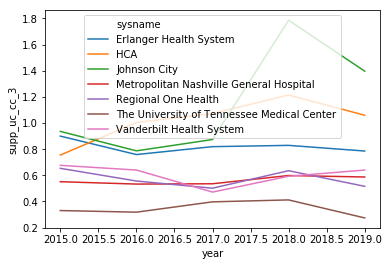

In [79]:
# looking at trendlines by select system
sns.lineplot(data = sysdf[(sysdf.sysname.isin(tgsys)) & (sysdf.year > 2014)], x = 'year', y = 'supp_uc_cc_3', hue = 'sysname');

In [80]:
# how much of their UC was covered, three years before supplemental 
supp_uc_cc_3_pv = add_diff(sysdf.pivot_table(columns = 'year',index = 'sysname', values = 'supp_uc_cc_3'),2019,2015)
supp_uc_cc_3_pv = supp_uc_cc_3_pv.reset_index()
print('Supplemental as percentage of uncompensated care (no bad debt), three years ago, select systems')
supp_uc_cc_3_pv[supp_uc_cc_3_pv.sysname.isin(tgsys)]

Supplemental as percentage of uncompensated care (no bad debt), three years ago, select systems


year,sysname,2015,2016,2017,2018,2019,diff
13,Erlanger Health System,0.899959,0.758822,0.819310,0.829096,0.785873,-0.126768
14,HCA,0.755116,1.003957,1.072699,1.213954,1.059568,0.403187
19,Johnson City,0.935898,0.787321,0.873693,1.785770,1.396544,0.492197
26,Metropolitan Nashville General Hospital,0.551337,0.533140,0.535576,0.598591,0.587234,0.065108
31,Regional One Health,0.653633,0.556552,0.501618,0.635397,0.515913,-0.210700
36,The University of Tennessee Medical Center,0.330719,0.318355,0.397337,0.412092,0.274451,-0.170138
38,Vanderbilt Health System,0.676430,0.640459,0.472011,0.592970,0.640298,-0.053415


It seems that for non-safety net hospitals, supplemental payment has been covering a declining share of uncompensated care regardless of whether we look at current year, two years ago, or three years ago. It was differnet for safety net hospitals - supplemental payment has been covering a steady share of uncompensated care two or three years before, but it covers a declining share of UC in the same year. 

### Medicaid adjusted inpatient days
Medicaid adjsuted inpatient days is a way to look at how much Medicaid care a hospital has been offering. It takes into account cost accured by outpatient visits as well.

In [81]:
print('Medicaid adjusted inpatient days,all providers')
gb = data.groupby(['year']).medicaid_adjusted_inpatient.sum()
gb

Medicaid adjusted inpatient days,all providers


year
2012    1.361243e+06
2013             inf
2014    1.343839e+06
2015    1.457354e+06
2016    1.525610e+06
2017    1.496049e+06
2018    1.511738e+06
2019    1.510238e+06
Name: medicaid_adjusted_inpatient, dtype: float64

In [82]:
#for safety nets as a whole
gb = data.groupby(['type','year']).medicaid_adjusted_inpatient.sum()
add_diff(make_pivot(gb, col = 'year',idx = 'type', val = None), 2019,2015)

,,2012,2013,2014,2015,2016,2017,2018,2019,diff
0,non_safety_net,1.034118e+06,inf,1.016684e+06,1.087181e+06,1.133071e+06,1.105011e+06,1.129635e+06,1.106735e+06,0.017986
1,safety_net,3.271247e+05,3.386560e+05,3.271545e+05,3.701729e+05,3.925389e+05,3.910373e+05,3.821033e+05,4.035024e+05,0.090038


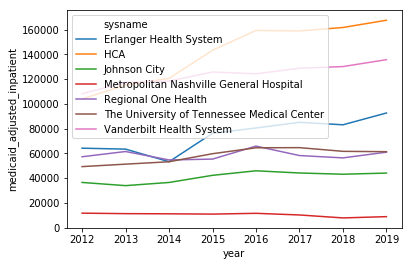

In [83]:
# looking at trendlines
sns.lineplot(data = sysdf[sysdf.sysname.isin(tgsys)], x = 'year', y = 'medicaid_adjusted_inpatient', hue = 'sysname');

In [84]:
add_diff(sysdf[sysdf.sysname.isin(tgsys)].pivot_table(columns = 'year',index = 'sysname', values = 'medicaid_adjusted_inpatient'),2019,2015)

year,2012,2013,2014,2015,2016,2017,2018,2019,diff
sysname,,,,,,,,,
Erlanger Health System,64164.693254,63415.442546,53248.116543,76238.680188,80492.917754,85083.642133,83081.004051,92604.865638,0.214670
HCA,103937.140488,115165.183903,120597.708378,143289.995663,159344.542461,158905.118737,161714.077904,167564.037729,0.169405
Johnson City,36483.163980,33912.290456,36474.249988,42239.263428,45898.031174,44128.601355,43123.382004,44054.226309,0.042969
Metropolitan Nashville General Hospital,11673.100697,11269.781326,11138.885931,10907.862744,11536.225347,10204.005213,7820.662324,8848.183316,-0.188825
Regional One Health,57244.982513,61483.343844,54668.021829,55354.537384,65846.197023,58221.375742,56330.359338,60946.946261,0.101029
The University of Tennessee Medical Center,49283.568915,51276.870547,53200.611644,59709.869979,64492.954588,64612.134572,61622.254994,61345.984516,0.027401
Vanderbilt Health System,108275.214596,117298.285179,118424.590510,125722.718677,124272.580576,128787.510341,130125.605602,135702.222888,0.079377


It seems that the Medicaid adjusted inpatient days have risen for safety-nets, and there is variation from system to system

 ### Medicaid percentage of adjusted inpatient days

In [85]:
print('Medicaid percentage of adjusted inpatient days,all providers')
gb = data[data.type != 'safety_net'].groupby(['year']).medicaid_adjusted_inpatient.sum()/data[data.type != 'safety_net'].groupby(['year']).total_adjusted_inpatient.sum()
gb

Medicaid percentage of adjusted inpatient days,all providers


year
2012    0.162054
2013         inf
2014    0.160205
2015    0.162930
2016    0.174178
2017    0.167988
2018    0.164546
2019    0.170282
dtype: float64

In [86]:
print('Medicaid percentage of adjusted inpatient days, safety-net vs. non-safety-net')
gb = data.groupby(['type','year']).medicaid_adjusted_inpatient.sum()/data.groupby(['type','year']).total_adjusted_inpatient.sum()
add_diff(make_pivot(gb, col = 'year',idx = 'type', val = None), 2019,2015)

Medicaid percentage of adjusted inpatient days, safety-net vs. non-safety-net


,,2012,2013,2014,2015,2016,2017,2018,2019,diff
0,non_safety_net,0.162054,inf,0.160205,0.162930,0.174178,0.167988,0.164546,0.170282,0.045122
1,safety_net,0.236967,0.23487,0.219095,0.232768,0.244910,0.239737,0.228303,0.229712,-0.013128


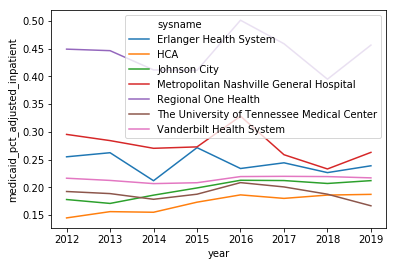

In [87]:
# looking at trendlines
sns.lineplot(data = sysdf[sysdf.sysname.isin(tgsys)], x = 'year', y = 'medicaid_pct_adjusted_inpatient', hue = 'sysname');

In [88]:
add_diff(sysdf[sysdf.sysname.isin(tgsys)].pivot_table(columns = 'year',index = 'sysname', values = 'medicaid_pct_adjusted_inpatient'),2019,2015)

year,2012,2013,2014,2015,2016,2017,2018,2019,diff
sysname,,,,,,,,,
Erlanger Health System,0.254917,0.262280,0.211817,0.271427,0.233836,0.244099,0.226444,0.238745,-0.120408
HCA,0.144794,0.156116,0.154999,0.173165,0.186309,0.179992,0.185950,0.187250,0.081335
Johnson City,0.177936,0.170908,0.185824,0.198799,0.212619,0.212121,0.206866,0.211983,0.066316
Metropolitan Nashville General Hospital,0.295281,0.284120,0.270236,0.272781,0.328135,0.258672,0.233021,0.262908,-0.036194
Regional One Health,0.448929,0.446191,0.411493,0.410777,0.501007,0.458680,0.394779,0.456221,0.110630
The University of Tennessee Medical Center,0.192391,0.188619,0.178366,0.187532,0.208395,0.200641,0.187535,0.166646,-0.111371
Vanderbilt Health System,0.216330,0.212358,0.206604,0.208215,0.219318,0.219734,0.219263,0.216955,0.041975


### Medicaid percentage of revenue
This is one of the proxies for payer mix. A hospital with a payer mix that is less Medicare/Medicaid and more commercial payors is more able to cover uncompensated care costs and therefore stay float and turn a profit.

In [89]:
print('Medicaid percentage of revenue, all providers')
data.groupby('year').medicaid_revenue.sum()/data.groupby('year').net_patient_revenue.sum()

Medicaid percentage of revenue, all providers


year
2012    0.113765
2013    0.115257
2014    0.114010
2015    0.113579
2016    0.119555
2017    0.112941
2018    0.110551
2019    0.107587
dtype: float64

In [90]:
#for safety nets as a whole 
gb = data.groupby(['type','year']).medicaid_revenue.sum()/data.groupby(['type','year']).net_patient_revenue.sum()
add_diff(make_pivot(gb, col = 'year',idx = 'type', val = None), 2019,2015)

,,2012,2013,2014,2015,2016,2017,2018,2019,diff
0,non_safety_net,0.104496,0.107622,0.107785,0.105887,0.108164,0.102429,0.097244,0.095637,-0.096797
1,safety_net,0.142268,0.139593,0.132484,0.135204,0.154325,0.143247,0.148373,0.139684,0.033134


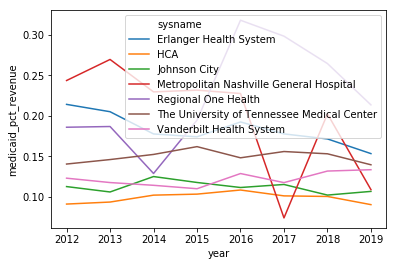

In [91]:
# looking at trendlines
sns.lineplot(data = sysdf[sysdf.sysname.isin(tgsys)], x = 'year', y = 'medicaid_pct_revenue', hue = 'sysname');

In [92]:
add_diff(sysdf[sysdf.sysname.isin(tgsys)].pivot_table(columns = 'year',index = 'sysname', values = 'medicaid_pct_revenue'),2019,2015)

year,2012,2013,2014,2015,2016,2017,2018,2019,diff
sysname,,,,,,,,,
Erlanger Health System,0.214124,0.205034,0.177520,0.173970,0.192359,0.177572,0.171350,0.153185,-0.119477
HCA,0.090706,0.093210,0.101758,0.103016,0.108109,0.100848,0.100132,0.090001,-0.126336
Johnson City,0.112359,0.105685,0.124774,0.117444,0.111217,0.114973,0.101838,0.106401,-0.094030
Metropolitan Nashville General Hospital,0.243661,0.269727,0.229572,0.231747,0.227578,0.073567,0.202311,0.108597,-0.531400
Regional One Health,0.185822,0.186717,0.128576,0.194544,0.318274,0.298545,0.264642,0.213477,0.097320
The University of Tennessee Medical Center,0.140260,0.145809,0.152156,0.161813,0.147980,0.155755,0.152942,0.139355,-0.138790
Vanderbilt Health System,0.122752,0.117344,0.113937,0.109693,0.128496,0.117277,0.131576,0.133246,0.214717


### Medicaid percentage of charges
Another way to look at payer mix.

In [93]:
print('Medicaid percentage of charges, all providers')
data.groupby('year').medicaid_charges.sum()/data.groupby('year').total_charges.sum()

Medicaid percentage of charges, all providers


year
2012    0.156319
2013    0.155607
2014    0.156332
2015    0.161729
2016    0.166155
2017    0.164593
2018    0.158977
2019    0.157699
dtype: float64

In [94]:
#for safety nets as a whole 
gb = data.groupby(['type','year']).medicaid_charges.sum()/data.groupby(['type','year']).total_charges.sum()
add_diff(make_pivot(gb, col = 'year',idx = 'type', val = None), 2019,2015)

,,2012,2013,2014,2015,2016,2017,2018,2019,diff
0,non_safety_net,0.146158,0.146364,0.148878,0.154141,0.156473,0.154626,0.151520,0.148450,-0.036926
1,safety_net,0.191227,0.187893,0.182538,0.187863,0.199530,0.198610,0.183709,0.187083,-0.004153


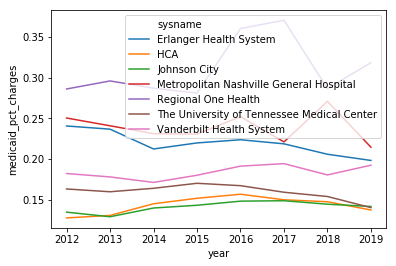

In [95]:
# looking at trendlines
sns.lineplot(data = sysdf[sysdf.sysname.isin(tgsys)], x = 'year', y = 'medicaid_pct_charges', hue = 'sysname');

In [96]:
add_diff(sysdf[sysdf.sysname.isin(tgsys)].pivot_table(columns = 'year',index = 'sysname', values = 'medicaid_pct_charges'),2016,2012)

year,2012,2013,2014,2015,2016,2017,2018,2019,diff
sysname,,,,,,,,,
Erlanger Health System,0.240579,0.236665,0.212326,0.219744,0.223659,0.218634,0.205841,0.198217,-0.070328
HCA,0.127596,0.130673,0.144989,0.151730,0.156706,0.149884,0.147450,0.137324,0.228140
Johnson City,0.134678,0.129035,0.139756,0.143158,0.148194,0.148722,0.144448,0.141637,0.100360
Metropolitan Nashville General Hospital,0.250362,0.240823,0.231134,0.230515,0.252086,0.221012,0.270818,0.214492,0.006888
Regional One Health,0.286041,0.295942,0.287036,0.281039,0.360362,0.370516,0.286521,0.318424,0.259826
The University of Tennessee Medical Center,0.163168,0.159734,0.164005,0.170149,0.167219,0.159148,0.153910,0.140237,0.024828
Vanderbilt Health System,0.182147,0.177964,0.171233,0.180038,0.191222,0.194293,0.180433,0.192370,0.049824


It seems that for all hospitals, regardless of whether they are safety nets, the share of resources provided to Medicaid patients has stayed relatively stable from 2015 to 2019.

### Number of uninsured patients

In [97]:
#for safety nets as a whole 
gb = data.groupby(['type','year']).total_uninsured_cnt.sum()
add_diff(make_pivot(gb, col = 'year',idx = 'type', val = None), 2019,2016)

,,2012,2013,2014,2015,2016,2017,2018,2019,diff
0,non_safety_net,0.0,0.0,0.0,0.0,509808.0,633299.0,648102.0,773992.0,0.518203
1,safety_net,0.0,0.0,0.0,0.0,120247.0,125473.0,210632.0,201356.0,0.674520


In [98]:
add_diff(sysdf[sysdf.sysname.isin(tgsys)].pivot_table(columns = 'year',index = 'sysname', values = 'total_uninsured_cnt'),2019,2016)

year,2012,2013,2014,2015,2016,2017,2018,2019,diff
sysname,,,,,,,,,
Erlanger Health System,0.0,0.0,0.0,0.0,33057.0,50765.0,60555.0,61290.0,0.854070
HCA,0.0,0.0,0.0,0.0,108153.0,106934.0,113448.0,115604.0,0.068893
Johnson City,0.0,0.0,0.0,0.0,12272.0,11892.0,11926.0,12269.0,-0.000244
Metropolitan Nashville General Hospital,0.0,0.0,0.0,0.0,0.0,0.0,38039.0,32209.0,inf
Regional One Health,0.0,0.0,0.0,0.0,36114.0,20895.0,53656.0,52572.0,0.455724
The University of Tennessee Medical Center,0.0,0.0,0.0,0.0,17029.0,16725.0,17736.0,18254.0,0.071936
Vanderbilt Health System,0.0,0.0,0.0,0.0,21775.0,25196.0,28720.0,24762.0,0.137176


### Supplemental Payment as a percentage of gross profit

In [99]:
#for safety nets as a whole 
gb = data.groupby(['type','year']).total_supplemental.sum()/data.groupby(['type','year']).gross_profit.sum()
add_diff(make_pivot(gb, col = 'year',idx = 'type', val = None), 2019,2015)

,,2012,2013,2014,2015,2016,2017,2018,2019,diff
0,non_safety_net,0.0,0.0,0.0,0.452116,0.370508,0.269823,0.374329,0.304724,-0.326004
1,safety_net,0.0,0.0,0.0,0.845860,0.734969,0.388727,0.575906,0.504330,-0.403767


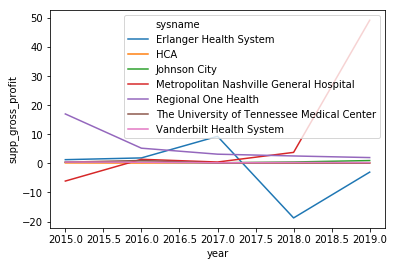

In [100]:
# looking at trendlines
sns.lineplot(data = sysdf[(sysdf.sysname.isin(tgsys)) & (sysdf.year > 2014)], x = 'year', y = 'supp_gross_profit', hue = 'sysname');

In [101]:
add_diff(sysdf[sysdf.sysname.isin(tgsys)].pivot_table(columns = 'year',index = 'sysname', values = 'supp_gross_profit'),2019,2015)

year,2012,2013,2014,2015,2016,2017,2018,2019,diff
sysname,,,,,,,,,
Erlanger Health System,0.0,0.0,0.0,1.285608,1.888809,9.307316,-18.742875,-2.997099,-3.331269
HCA,0.0,0.0,0.0,0.178229,0.135543,0.234288,0.233556,0.170326,-0.044342
Johnson City,0.0,0.0,0.0,0.416598,0.436636,0.203955,0.491187,0.979462,1.351096
Metropolitan Nashville General Hospital,0.0,0.0,0.0,-6.069060,1.413032,0.476020,3.790654,49.228471,-9.111383
Regional One Health,0.0,0.0,0.0,17.006329,5.233787,3.174561,2.560709,2.005092,-0.882097
The University of Tennessee Medical Center,0.0,0.0,0.0,0.440329,1.000061,0.143436,0.144916,0.102387,-0.767476
Vanderbilt Health System,0.0,0.0,0.0,0.474564,0.398892,0.211163,0.333234,0.286355,-0.396593
